# Week 4 - Exploring Semantic Spaces (Word Embeddings)
This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them.

This is our third document representation we have learned: First, we used word counts. Second, we used LDA topic models built around term coocurrence in the same document (i.e., a "bag of words"). Third, documents here are represented as densely indexed locations in dimensions, so that distances between those documents (and words) contain more information, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

Note that most modern natural language processing (NLP) research, at least in computer science, uses word embeddings. This is the foundation of most state-of-the-art models.

Also note that the code in this Notebook can take many minutes or even hours to run. This is the case for most NLP research these days, and it's a good opportunity to start thinking about how to manage high-compute workloads, such as running code on small samples to test it, loading datafiles in [chunks](https://stackoverflow.com/a/25962187), or [multiprocessing](https://en.wikipedia.org/wiki/Multiprocessing).

## <font color="red">*Pitch Your Project*</font>

<font color="red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

# ***What?*** 
<200 words

## ***Why?***
<200 words

## ***How?***
<400 words

## <font color="red">*Pitch Your Sample*</font>

<font color="red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

## ***Which (words)?***
<300 words

In [3]:
#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import lucem_illud #pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git

import numpy as np #For arrays
import pandas as pd #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths
import multiprocessing

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, but first we need to define a function to convert directories of text files into DataFrames:

In [16]:
def loadDir(targetDir, category):
    allFileNames = os.listdir(targetDir)
    #We need to make them into usable paths and filter out hidden files
    filePaths = [os.path.join(targetDir, fname) for fname in allFileNames if fname[0] != '.']

    #The dict that will become the DataFrame
    senDict = {
        'category' : [category] * len(filePaths),
        'filePath' : [],
        'text' : [],
    }

    for fPath in filePaths:
        with open(fPath) as f:
# Try this line instead if you get an encoding error.
#         with open(fPath, encoding="ISO-8859-1") as f:
            senDict['text'].append(f.read())
            senDict['filePath'].append(fPath)

    return pd.DataFrame(senDict)

Now we can use the function in all the directories in `data/grimmerPressReleases`. If you are on Google Colab, note that rather than downloading GitHub data to your local machine and then uploading it to Drive, you can more quickly `git clone` directly to Colab, such as `!git clone https://github.com/lintool/GrimmerSenatePressReleases.git /drive/MyDrive/`, which then makes your `dataDir = 'drive/MyDrive/grimmerPressReleases/raw'`.

In [17]:
#dataDir = 'content/drive/MyDrive/grimmerPressReleases/raw'
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pd.DataFrame()

for senatorName in [d for d in os.listdir(dataDir) if d[0] != '.']:
    senPath = os.path.join(dataDir, senatorName)
    senReleasesDF = senReleasesDF.append(loadDir(senPath, senatorName), ignore_index = True)

senReleasesDF[:100:10]

,category,filePath,text
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...


Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone.

When we normalize here, we don't use the lematized form of the word because we might lose information. Note the paramter in the normalize tokens function.

In [18]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
#senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, lemma=False) for s in x])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

senReleasesDF[:100:10]

/Users/sudhamshu.hosamane/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:187: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


,category,filePath,text,tokenized_sents,normalized_sents
0,Klobuchar,../data/grimmerPressReleases/Klobuchar/22May20...,...,"[[Klobuchar, Features, Fergus, Falls, Bakery, ...","[[klobuchar, features, fergus, falls, bakery, ..."
10,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Aug20...,...,"[[Sen, Klobuchar, Showcases, Local, Efforts, t...","[[sen, klobuchar, showcases, local, efforts, c..."
20,Klobuchar,../data/grimmerPressReleases/Klobuchar/17Jul20...,...,"[[Klobuchar, Urges, Fellow, Senators, to, Supp...","[[klobuchar, urges, fellow, senators, support,..."
30,Klobuchar,../data/grimmerPressReleases/Klobuchar/14Dec20...,...,"[[Senator, Klobuchar, Wins, Passage, of, Cellu...","[[senator, klobuchar, wins, passage, cellulosi..."
40,Klobuchar,../data/grimmerPressReleases/Klobuchar/22Jan20...,...,"[[Klobuchar, Gives, Beyond, the, Yellow, Ribbo...","[[klobuchar, gives, yellow, ribbon, place, arm..."
50,Klobuchar,../data/grimmerPressReleases/Klobuchar/28May20...,...,"[[Sen, Klobuchar, Statement, in, Observance, o...","[[sen, klobuchar, statement, observance, memor..."
60,Klobuchar,../data/grimmerPressReleases/Klobuchar/27Jun20...,...,"[[Klobuchar, Secures, 2, 5, Million, for, Vete...","[[klobuchar, secures, veterans, education, hea..."
70,Klobuchar,../data/grimmerPressReleases/Klobuchar/01Nov20...,...,"[[Klobuchar, Carbon, Counter, Passes, First, C...","[[klobuchar, carbon, counter, passes, committe..."
80,Klobuchar,../data/grimmerPressReleases/Klobuchar/24Jan20...,...,"[[Sen, Klobuchar, Urges, Minnesotans, Travelin...","[[sen, klobuchar, urges, minnesotans, travelin..."
90,Klobuchar,../data/grimmerPressReleases/Klobuchar/23Jan20...,...,"[[Klobuchar, Co, sponsors, Emergency, LIHEAP, ...","[[klobuchar, co, sponsors, emergency, liheap, ..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec). Note that newer versions of gensim have different syntax, but if you're using a newer version, you should see informative error messages (e.g., replace `senReleasesW2V['president'][:10]` with `senReleasesW2V['president'].wv[:10]`). The following lines should work out-of-the-box on Google Colab.

To load our data our data we give all the sentences to the trainer:

In [23]:
# The sg=0 argument indicates that we don't want to use "skipgram" but instead "CBOW"
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum(), sg=0)

Inside the word2vec object, each word has a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [24]:
senReleasesW2V.wv['president'][:10] #Shortening because it's very large

array([-0.08379821, -1.4981356 ,  0.15945822, -1.7696685 ,  0.43357664,
        0.8399274 , -0.4595735 ,  1.505612  , -1.628882  ,  1.5121825 ],
      dtype=float32)

If you want the full matrix, `syn0` stores all the vectors:

In [25]:
senReleasesW2V.wv.vectors

array([[ 3.1493691e-01,  6.0303450e-01,  2.5718815e+00, ...,
        -4.5606989e-01,  1.1879054e+00,  1.0987238e-01],
       [ 1.0475113e+00, -8.1135255e-01,  1.6574159e+00, ...,
        -8.0665678e-01,  4.1781542e-01, -2.3502243e-01],
       [ 1.6113275e+00,  1.0459845e+00, -1.3620894e+00, ...,
         1.1211504e+00,  1.6696674e-01, -8.8768494e-01],
       ...,
       [ 1.4075235e-03,  2.4462154e-02, -6.8796329e-02, ...,
        -2.9525496e-02,  5.0520703e-02, -1.7584706e-02],
       [ 3.7596606e-02, -6.5803099e-03,  4.7101259e-02, ...,
        -3.3216301e-02,  4.4417333e-02, -2.5393978e-02],
       [ 1.0074497e-02,  3.8975455e-02, -5.8168110e-02, ...,
        -7.6803334e-02,  5.6433361e-02, -1.0968686e-02]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words:

In [26]:
senReleasesW2V.wv.index_to_key[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [27]:
senReleasesW2V.wv.most_similar('president')

[('administration', 0.8046438694000244),
 ('presidents', 0.7363481521606445),
 ('administrations', 0.709456205368042),
 ('cheney', 0.6221266388893127),
 ('veto', 0.5389695167541504),
 ('george', 0.523818850517273),
 ('ronald', 0.5236360430717468),
 ('presidential', 0.5198289752006531),
 ('jeopardizes', 0.5153281688690186),
 ('responds', 0.5115595459938049)]

In [28]:
senReleasesW2V.wv.most_similar('war')

[('disobedience', 0.6516045928001404),
 ('compounding', 0.6459616422653198),
 ('wars', 0.6405795216560364),
 ('chaos', 0.63911372423172),
 ('escalation', 0.6388864517211914),
 ('afghanistan', 0.6302603483200073),
 ('unwinnable', 0.62705397605896),
 ('descending', 0.6222507953643799),
 ('quagmire', 0.6217554807662964),
 ('unresisted', 0.6124473810195923)]

Find which word least matches the others within a word set (cosine similarity):

In [29]:
senReleasesW2V.wv.doesnt_match(['administration', 'administrations',
                              'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [30]:
senReleasesW2V.wv.most_similar(positive=['clinton', 'republican'], negative =
['democrat'])

[('vetoes', 0.6973586082458496),
 ('signed', 0.6849859356880188),
 ('veto', 0.6775559782981873),
 ('vetoed', 0.6479910016059875),
 ('bushs', 0.6415197849273682),
 ('signature', 0.6362400650978088),
 ('roosevelt', 0.6291850805282593),
 ('bush', 0.6157872676849365),
 ('nixon', 0.6156591176986694),
 ('saying', 0.6136648654937744)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset, **Clinton** is to **Democrat** as **Bush** is to **Republican**. Whoah!

We can also save the vectors for later use:

In [34]:
senReleasesW2V.save("senpressreleasesWORD2Vec")

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [57]:
numWords = 150
targetWords = senReleasesW2V.wv.index_to_key[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [58]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[ 0.3149369 ,  0.6030345 ,  2.5718815 , ..., -0.4560699 ,
         1.1879054 ,  0.10987238],
       [ 1.0475113 , -0.81135255,  1.6574159 , ..., -0.8066568 ,
         0.41781542, -0.23502243],
       [ 1.6113275 ,  1.0459845 , -1.3620894 , ...,  1.1211504 ,
         0.16696674, -0.88768494],
       ...,
       [-0.0314204 ,  0.3703452 , -1.4447932 , ..., -1.7699103 ,
        -1.0963607 ,  0.15209624],
       [-1.1961448 ,  1.215971  ,  0.00769479, ..., -1.3587874 ,
         0.9363667 , -0.3374859 ],
       [ 1.91236   ,  1.7318903 , -0.5579251 , ...,  0.93645304,
         0.16308628, -1.0211785 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and T-SNE to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [59]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

We now can plot the points

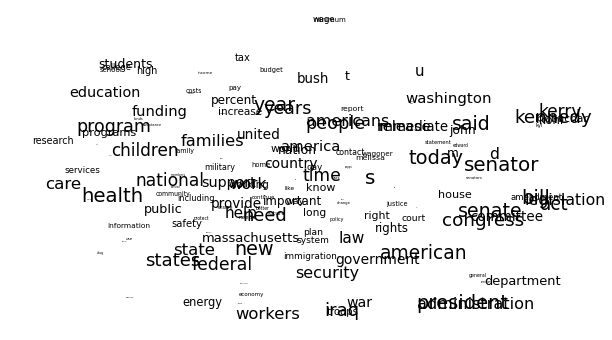

In [60]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 *
                                                                       (numWords - i) / numWords)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``said`` next to ``congress`` and ``bill`` near ``act``. ``health`` is beside ``care`` and ``national`` abuts ``security``.

# Chinese examples
The following datafile is [available on Canvas](https://canvas.uchicago.edu/courses/39937/files/6674623/download). The Chinese word2vec model we use in this assignment was made with an old version of Gensim. If you have a version of '4.0.0' or later, you can run code like `!pip install gensim==3.8.3` (the last v3 of Gensim before v4) and restart your notebook to load that file. However, it's usually best to use the most recent stable versions of Python packages, so you can skip this section and go straight to the FastText section if you would like.

In [25]:
# !pip install gensim==3.8.3

In [26]:
import gensim
gensim.__version__

'4.0.1'

In [27]:
import gensim
gensim.__version__

'4.0.1'

In [28]:
# If your version is 4.0.0 or later, this code will raise `AttributeError: Can't get attribute 'Vocab'...`
# You can load an old version of Gensim or skip to FastText.
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/Users/sudhamshu.hosamane/opt/anaconda3/lib/python3.8/site-packages/gensim/models/word2vec.py'>

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.wv.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

In [ ]:
mm = model.wv.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

Second, location analogy: **country -> capital**

In [ ]:
mm = model.wv.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.wv.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

In [ ]:
#@title
word = u'玉米'  # corn
ss = model.wv.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

## Adding more context - FastText

Since the original word2vec paper, there have followed a slew of word embedding related methods which innovate and build on them in many ways. One popular extension is FastText ([Bojanowski et al. 2017](https://arxiv.org/abs/1607.04606)), which uses sub-words to generate its vectors. Using subwords means that it is powerful in dealing with unknown words and sparse languages that otherwise have a rich morphological structure. These sub-words are incorporated into the previously skipgram and CBOW methods. For example, if the word is “which”, it is represented as the word itself along with a bag of constituent n-grams. If n=3, the representation looks like <wh, whi, hic, ich, ch>, and we learn a representation for each of these constituents, with the word “which” taking on the average value of these constituents. 

FastText can be used either via Gensim or the official package, and primarily has two functions - word representations, and text classification (Joulin et al. 2017). See below for code using the FastText package for playing with word representations, taken from their word representations tutorial (https://fasttext.cc/docs/en/unsupervised-tutorial.html).


In [ ]:
! pip install fasttext

### Representations with FastText

We will follow the instructions in the FastText tutorial to prepare our data, (Wikipedia). You can either follow the instructions on the page for setting the data, or download/copy it to drive it from this [Google Drive link](https://drive.google.com/file/d/12T3nNzf0a7tdhm1lVyfz9Ix9XVITFMCP/view?usp=sharing). 

In this example, we will be training a model - it is also possible to download and use the many pre-trained models.

In [30]:
!pip install fasttext

     |████████████████████████████████| 68 kB 1.4 MB/s eta 0:00:01
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp38-cp38-macosx_10_16_x86_64.whl size=350663 sha256=7c17765f3fac295f7fb3405e9615fcd6bbf8f7f21f7f4321cc9b71d8f57f466e
  Stored in directory: /Users/sudhamshu.hosamane/Library/Caches/pip/wheels/93/61/2a/c54711a91c418ba06ba195b1d78ff24fcaad8592f2a694ac94
Successfully built fasttext


In [2]:
import fasttext

In [1]:
# Replace with the path for where you have placed the 'fil9' file.
file_address = "../data/fil9"

In [3]:
model = fasttext.train_unsupervised(file_address)

While FastText is running, the progress and estimated time to completion is shown on your screen. Once the training finishes, the model variable contains information on the trained model, which you can use for querying:



In [5]:
model.words

['the',
 'of',
 'and',
 'in',
 'a',
 'to',
 'is',
 'The',
 'are',
 'for',
 'was',
 'as',
 'with',
 'by',
 'from',
 'that',
 'on',
 'or',
 'at',
 'an',
 'his',
 'have',
 'which',
 'it',
 'In',
 'be',
 'age',
 'also',
 'he',
 'has',
 'were',
 'not',
 'who',
 'had',
 'population',
 'this',
 'but',
 'km',
 'other',
 'there',
 'their',
 'one',
 'under',
 'A',
 'more',
 '18',
 'its',
 'all',
 'living',
 'first',
 'two',
 'income',
 'median',
 'been',
 'It',
 'out',
 'total',
 'United',
 'can',
 'For',
 'years',
 'they',
 'This',
 'He',
 'into',
 'There',
 'most',
 'city',
 'average',
 'As',
 'such',
 'used',
 '65',
 'some',
 'up',
 'no',
 'mi.',
 'New',
 'those',
 'many',
 'only',
 'made',
 'after',
 'than',
 'would',
 'when',
 'American',
 'family',
 'area',
 'any',
 'every',
 'States',
 'town',
 '100',
 'known',
 'links',
 'External',
 'her',
 'about',
 'County,',
 'located',
 'size',
 'below',
 'may',
 'between',
 'over',
 'time',
 '1',
 'families',
 'density',
 'line.',
 'called',
 'hous

It returns all words in the vocabulary, sorted by decreasing frequency. We can get the word vector by:



In [6]:
model.get_word_vector("the")

array([ 0.21780829,  0.5420641 ,  0.14020798,  0.03153656, -0.21554717,
       -0.01463629, -0.1172088 , -0.25665608,  0.45933706, -0.07181622,
       -0.01901388,  0.15529796,  0.14074008,  0.2982834 , -0.38236123,
        0.2971744 ,  0.11076943, -0.13008904,  0.1767001 , -0.01376326,
        0.00286228, -0.48700485, -0.19165877,  0.01501795, -0.17052041,
        0.22551504,  0.369185  , -0.05285529,  0.17850073,  0.11102227,
       -0.24140362, -0.12735684, -0.62862265,  0.23121265,  0.2346859 ,
       -0.05977695, -0.17239645,  0.15485437,  0.02714259, -0.08692344,
        0.3450655 ,  0.25120735, -0.34156135,  0.04917753,  0.1893681 ,
       -0.28861538,  0.01568804, -0.29335678,  0.13705522, -0.33754915,
        0.24719574,  0.42809182,  0.04690401, -0.42033783,  0.3646212 ,
        0.16784628, -0.24660738,  0.06506067,  0.0518283 , -0.39931217,
        0.28820816,  0.04084602, -0.16487902,  0.27188417,  0.08581548,
        0.16312878,  0.21142857, -0.15846705, -0.09155051,  0.07

In [9]:
model.save_model("../data/fil9.bin")

In [10]:
# when we want to use the model again
# model = fasttext.load_model("result/fil9.bin")

Let's now print some vectors.

In [11]:
[model.get_word_vector(x) for x in ["asparagus", "pidgey", "yellow"]]

[array([-0.21800053,  0.4862138 , -0.5346452 ,  0.2744559 , -0.62850255,
         0.07684375, -0.5096484 ,  0.05491662,  0.5847092 ,  0.08803265,
        -0.43165606, -0.20340516, -0.13410752, -0.2534203 , -0.23496152,
        -0.06768491,  0.53906417, -0.21295683, -0.25137624, -0.37771562,
        -0.38342288, -0.63447464,  0.8980348 ,  0.47247493, -0.3722187 ,
         0.27976483, -0.35741732,  0.6268811 , -0.3175064 ,  0.26505774,
        -0.04810302, -0.06898915, -0.23737688, -0.18782198, -0.6497249 ,
         0.12959506, -0.3330148 , -0.5463684 , -0.40590292, -0.35104975,
         0.10180354, -0.7646931 , -0.46836612, -0.48575014,  0.1512935 ,
        -0.90911883,  0.2023169 ,  0.33933643,  0.47673324,  0.02373031,
         0.2776486 ,  0.30755824,  0.2140295 ,  0.01143821,  0.3603321 ,
         0.7943554 , -0.08022667,  0.18462993, -0.09673534, -0.5318201 ,
         0.37910375,  0.20623448, -0.6656971 ,  0.34505695,  0.05015637,
        -0.03690154,  0.83024293, -0.5461427 , -0.2

A nice feature is that you can also query for words that did not appear in your data! Indeed words are represented by the sum of their substrings. As long as the unknown word is made of known substrings, there is a representation of it!

As an example let's try with a misspelled word:



In [12]:
model.get_word_vector("enviroment")

array([-0.25259894,  0.12307895,  0.07333405, -0.22569385, -0.11816209,
        0.2713201 , -0.14851011, -0.01965292,  0.00167094, -0.2108514 ,
        0.02147358,  0.27318236,  0.23385288, -0.05572356,  0.00765173,
       -0.19938426,  0.3435686 ,  0.14765936,  0.23987678, -0.18956414,
       -0.09978163, -0.46087536,  0.271125  ,  0.57333326,  0.45783773,
        0.09215032,  0.07153235,  0.1339179 ,  0.17967619, -0.35571572,
       -0.00084564,  0.03788147, -0.554607  ,  0.1811055 ,  0.32604086,
       -0.37882727, -0.31118044,  0.149269  ,  0.02524346, -0.33956107,
       -0.3286787 , -0.35280928, -0.31613365, -0.2706435 ,  0.36637023,
       -0.08773998,  0.31460294,  0.30505016,  0.16883183, -0.08449019,
        0.39575467,  0.02763425, -0.16956295, -0.00543788,  0.3244421 ,
        0.6757046 , -0.27789876,  0.45599535,  0.0822728 , -0.3515321 ,
        0.16571586,  0.3528475 ,  0.05775394, -0.05644684,  0.29632807,
       -0.12561065,  0.6099383 ,  0.16126198, -0.37038475, -0.02

In [13]:
# Add FastText here

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using at least two different specification of `word2vec` and/or `fasttext`, and visualize them each with two separate visualization layout specifications (e.g., TSNE, PCA). Then interrogate critical word vectors within your corpus in terms of the most similar words, analogies, and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the semantic organization of words in your corpora? Which estimation and visualization specification generate the most insight and appear the most robustly supported and why? 

<font color="red">***Stretch***: Explore different vector calculations beyond addition and subtraction, such as multiplication, division or some other function. What does this exploration reveal about the semantic structure of your corpus?

In [1]:
netflix_overall = pd.read_csv('netflix_titles.csv', index_col=0)

NameError: name 'pd' is not defined

In [2]:
netflix_overall

NameError: name 'netflix_overall' is not defined

In [4]:
netflix_overall.dropna(inplace=True)

In [5]:
netflix_overall

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s8,Movie,Sankofa,Haile Gerima,"Kofi Ghanaba, Oyafunmike Ogunlano, Alexandra D...","United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",1993,TV-MA,125 min,"Dramas, Independent Movies, International Movies","On a photo shoot in Ghana, an American model s..."
s9,TV Show,The Great British Baking Show,Andy Devonshire,"Mel Giedroyc, Sue Perkins, Mary Berry, Paul Ho...",United Kingdom,"September 24, 2021",2021,TV-14,9 Seasons,"British TV Shows, Reality TV",A talented batch of amateur bakers face off in...
s10,Movie,The Starling,Theodore Melfi,"Melissa McCarthy, Chris O'Dowd, Kevin Kline, T...",United States,"September 24, 2021",2021,PG-13,104 min,"Comedies, Dramas",A woman adjusting to life after a loss contend...
s13,Movie,Je Suis Karl,Christian Schwochow,"Luna Wedler, Jannis Niewöhner, Milan Peschel, ...","Germany, Czech Republic","September 23, 2021",2021,TV-MA,127 min,"Dramas, International Movies",After most of her family is murdered in a terr...
s25,Movie,Jeans,S. Shankar,"Prashanth, Aishwarya Rai Bachchan, Sri Lakshmi...",India,"September 21, 2021",1998,TV-14,166 min,"Comedies, International Movies, Romantic Movies",When the father of the man she loves insists t...
...,...,...,...,...,...,...,...,...,...,...,...
s8802,Movie,Zinzana,Majid Al Ansari,"Ali Suliman, Saleh Bakri, Yasa, Ali Al-Jabri, ...","United Arab Emirates, Jordan","March 9, 2016",2015,TV-MA,96 min,"Dramas, International Movies, Thrillers",Recovering alcoholic Talal wakes up inside a s...
s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...


In [6]:
print(netflix_overall['description'][2])

A woman adjusting to life after a loss contends with a feisty bird that's taken over her garden — and a husband who's struggling to find a way forward.


In [7]:
netflix_overall['tokenised_words']= netflix_overall['description'].apply\
    (lambda x: lucem_illud.word_tokenize(x))

/Users/sudhamshu.hosamane/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:187: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [8]:
netflix_overall['normalised_words'] = netflix_overall['tokenised_words']\
    .apply(lambda x : lucem_illud.normalizeTokens(x))

In [187]:
nfW2V = gensim.models.word2vec.Word2Vec(netflix_overall['normalised_words'],
                                        sg=0, workers=8)

In [188]:
# nfW2V = gensim.models.word2vec.Word2Vec(netflix_overall['normalised_words'],
#                                         sg=1, workers=8, window=7, min_count=2)

In [189]:
netflix_overall['normalised_words']

show_id
s8       [photo, shoot, ghana, american, model, slips, ...
s9       [talented, batch, amateur, bakers, face, week,...
s10      [woman, adjusting, life, loss, contends, feist...
s13      [family, murdered, terrorist, bombing, young, ...
s25      [father, man, loves, insists, twin, sons, marr...
                               ...                        
s8802    [recovering, alcoholic, talal, wakes, inside, ...
s8803    [political, cartoonist, crime, reporter, pair,...
s8805    [looking, survive, world, taken, zombies, dork...
s8806    [dragged, civilian, life, superhero, train, ne...
s8807    [scrappy, poor, boy, worms, way, tycoon, dysfu...
Name: normalised_words, Length: 5332, dtype: object

In [190]:
# model = gensim.models.Word2Vec(sg=0)  # an empty model, no training yet
# model.build_vocab(netflix_overall['normalised_words'].sum())  # can be a non-repeatable, 1-pass generator
# model.train(netflix_overall['normalised_words'].sum())

In [191]:
nfW2V.wv.most_similar('love')

[('man', 0.9998483657836914),
 ('girl', 0.9998430609703064),
 ('couple', 0.9998422265052795),
 ('daughter', 0.9998403191566467),
 ('family', 0.999839723110199),
 ('finds', 0.9998393654823303),
 ('wife', 0.9998385310173035),
 ('gets', 0.9998248219490051),
 ('murder', 0.9998247623443604),
 ('new', 0.9998232126235962)]

In [192]:
nfW2V.wv.similarity('town','world')

0.99963206

In [193]:
nfW2V.wv.most_similar('romance')

[('young', 0.9998132586479187),
 ('past', 0.9997900128364563),
 ('home', 0.9997851848602295),
 ('gets', 0.9997838735580444),
 ('documentary', 0.9997833371162415),
 ('love', 0.9997791051864624),
 ('man', 0.9997790455818176),
 ('city', 0.9997768998146057),
 ('tries', 0.9997749924659729),
 ('soon', 0.9997724890708923)]

In [194]:
nfW2V.wv.most_similar('cop')

[('past', 0.999812662601471),
 ('gets', 0.999805212020874),
 ('life', 0.9998049736022949),
 ('finds', 0.999804675579071),
 ('home', 0.9998044967651367),
 ('documentary', 0.9997981190681458),
 ('wife', 0.9997966289520264),
 ('india', 0.9997950196266174),
 ('find', 0.9997888207435608),
 ('comedian', 0.999788761138916)]

In [195]:
nfW2V.wv.most_similar(positive=['cop','man'],negative=['wife'])

[('woman', 0.9996864199638367),
 ('soon', 0.999665379524231),
 ('home', 0.9996515512466431),
 ('life', 0.9996501207351685),
 ('finds', 0.9996451139450073),
 ('documentary', 0.9996436238288879),
 ('teen', 0.9996430277824402),
 ('couple', 0.9996404051780701),
 ('love', 0.9996402263641357),
 ('city', 0.9996389150619507)]

In [196]:
import random

In [197]:
numwords = 75
nfwords = random.sample(nfW2V.wv.index_to_key, numwords)

In [198]:
wordsSubMatrix = []
for word in nfwords:
    wordsSubMatrix.append(nfW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.07039984,  0.11420741,  0.02293617, ..., -0.11022286,
         0.0175783 ,  0.01735978],
       [-0.06857939,  0.10353766,  0.02186966, ..., -0.11316474,
         0.02915096,  0.00523255],
       [-0.07839161,  0.10909747,  0.02409442, ..., -0.11553281,
         0.0322054 ,  0.01407943],
       ...,
       [-0.05609105,  0.08031986,  0.02582975, ..., -0.08500837,
         0.009297  ,  0.01251782],
       [-0.01905653,  0.03875581,  0.00261674, ..., -0.0437824 ,
         0.00548374,  0.0117331 ],
       [-0.05470126,  0.08168177,  0.01288133, ..., -0.09316247,
         0.01081866,  0.01038548]], dtype=float32)

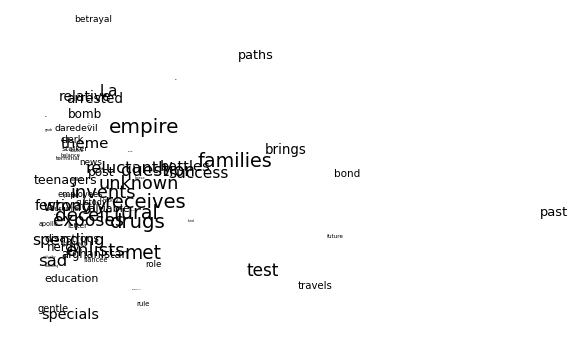

In [199]:
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
# tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(nfwords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (75 -  i) /  75)

plt.xticks(())
plt.yticks(())
plt.show()

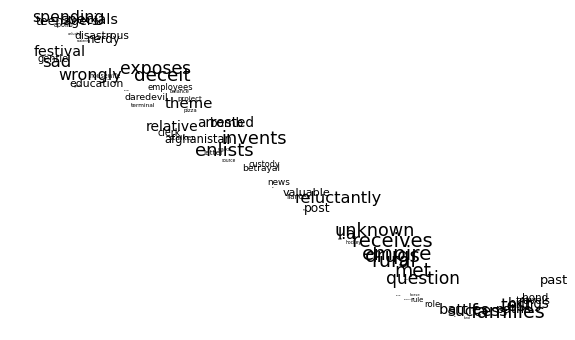

In [200]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(nfwords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (75 -  i) /  75)

plt.xticks(())
plt.yticks(())
plt.show()

In [209]:
nfW2V = gensim.models.word2vec.Word2Vec(netflix_overall['normalised_words'],
                                        sg=1, workers=8, window=3, min_count=2)

In [210]:
wordsSubMatrix = []
for word in nfwords:
    wordsSubMatrix.append(nfW2V.wv[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.05711868,  0.15549174,  0.05730131, ..., -0.18959442,
         0.06548034,  0.04679627],
       [-0.06157374,  0.16363016,  0.07167257, ..., -0.19132291,
         0.05324009,  0.04487355],
       [-0.04612016,  0.16590789,  0.06284983, ..., -0.18490887,
         0.05262949,  0.03014337],
       ...,
       [-0.03523898,  0.14563124,  0.05009499, ..., -0.16940585,
         0.04538195,  0.04033789],
       [-0.01796929,  0.09264041,  0.04240805, ..., -0.08732115,
         0.02618022,  0.02648111],
       [-0.04193744,  0.15539762,  0.06173969, ..., -0.1645075 ,
         0.04838059,  0.04985019]], dtype=float32)

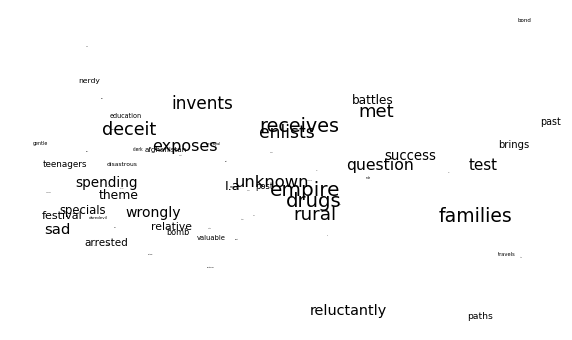

In [211]:
pcaWords = sklearn.decomposition.PCA(n_components = 2).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
# tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(nfwords):
    ax.annotate(word, (reducedPCA_data[:, 0][i],reducedPCA_data[:, 1][i]), size =  20 * (50 -  i) /  50)

plt.xticks(())
plt.yticks(())
plt.show()

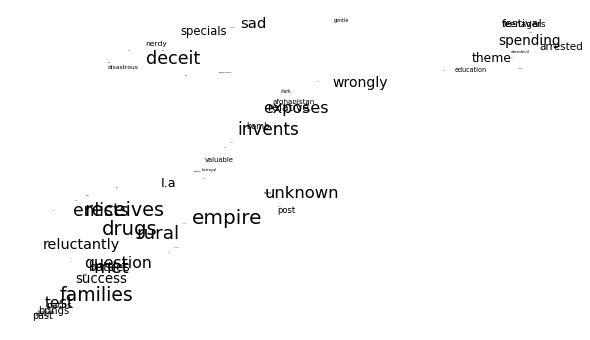

In [212]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_data)

fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible
for i, word in enumerate(nfwords):
    ax.annotate(word, (tsneWords[:, 0][i],tsneWords[:, 1][i]), size =  20 * (50 -  i) /  50)

plt.xticks(())
plt.yticks(())
plt.show()

Inference:

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [214]:
apsDF = pd.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags.

In [215]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [216]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: lucem_illud.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, lemma=False))

/Users/sudhamshu.hosamane/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:187: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [217]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words =
                                                             row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

Now we can train a Doc2Vec model:

In [218]:
cores = multiprocessing.cpu_count()

In [219]:
# PV-DBOW
model = gensim.models.doc2vec.Doc2Vec(dm=0, dbow_words=1, vector_size=100,
                                      window=8,
                                  min_count=19, epochs=10, workers=cores)
# PV-DM w/average
# gensim.models.doc2vec.Doc2Vec(dm=1, dm_mean=1, size=200, window=8,
#                               min_count=19, iter =10, workers=cores),


In [28]:
model.build_vocab(apsDF['TaggedAbstracts'])
print(str(model))

Doc2Vec(dbow+w,d100,n5,w8,mc19,s0.001,t8)


In [29]:
model.train(apsDF['TaggedAbstracts'], total_examples=model
                   .corpus_count, epochs=model.epochs)

In [40]:
apsD2V = model

In [41]:
# apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], vector_size= 100)
#Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [50]:
apsD2V[1952]

array([-0.23604801, -0.15555507, -0.01621937,  0.28149402,  0.174859  ,
        0.00543393,  0.03763226,  0.02749215,  0.38104516, -0.32950735,
       -0.07337065, -0.10271504,  0.01853523, -0.23445019,  0.07349247,
        0.01002256,  0.00064691, -0.2567666 ,  0.5073737 ,  0.02885728,
       -0.01563067,  0.12318384, -0.07086795,  0.17829706, -0.25724566,
       -0.18189847,  0.0083423 ,  0.15825294,  0.09329228, -0.07465659,
       -0.06264459, -0.13483328,  0.15815942, -0.15224132, -0.09644087,
       -0.23717387,  0.49047336,  0.38133317,  0.26086593, -0.01251832,
        0.21731895,  0.13667329, -0.05640685, -0.05502024, -0.59220374,
        0.54123616, -0.13224283,  0.12462702, -0.03046961, -0.24649675,
       -0.15661827,  0.05671579,  0.24080575, -0.00425018,  0.3335579 ,
        0.0026114 , -0.09167993,  0.16546069,  0.4276413 , -0.19416638,
       -0.1382584 ,  0.02824909,  0.23902962, -0.5706474 , -0.11822524,
        0.3616912 , -0.04646933,  0.19178008, -0.0587602 ,  0.06

The words can still be accessed in the same way:

In [49]:
apsD2V['electron']

array([ 2.40196690e-01, -1.67515963e-01, -1.65718906e-02, -1.43283367e-01,
       -2.25311778e-02, -1.45050157e-02,  1.43466786e-01, -3.70158590e-02,
        2.09785536e-01, -2.45597392e-01,  1.41236335e-01, -4.45653677e-01,
       -8.12914297e-02,  7.62302354e-02, -1.20826595e-01, -2.08162535e-02,
        2.32362852e-01, -2.12731492e-02,  2.08028764e-01, -2.68925846e-01,
       -2.10648492e-01,  3.15076739e-01,  7.33333603e-02, -1.00364834e-01,
       -1.43515483e-01,  1.78805992e-01,  1.29114345e-01,  5.13775945e-02,
        8.50861625e-07, -2.52559483e-02, -2.90475160e-01, -1.41595826e-01,
       -9.13075730e-02,  2.98843294e-01, -3.35425198e-01, -4.88766223e-01,
        4.06525940e-01,  2.31206492e-02,  1.29762128e-01,  1.36979476e-01,
        2.36262217e-01,  3.06909025e-01, -1.14059493e-01, -1.18168026e-01,
       -9.29483697e-02, -2.09514037e-01, -1.03113882e-01, -3.45522583e-01,
        5.43706678e-02,  5.28208427e-02,  9.54770669e-02,  1.59517080e-01,
        1.27695143e-01,  

We can still use the ``most_similar`` command to perform simple semantic equations:

In [52]:
apsD2V.wv.most_similar(positive = ['atom','electrons'], negative =
['electron'], topn = 10)

[('atoms', 0.6481179594993591),
 ('neighbors', 0.5025076270103455),
 ('adjacent', 0.4507785439491272),
 ('antiparallel', 0.4467345178127289),
 ('transferred', 0.4331967532634735),
 ('kinds', 0.43202510476112366),
 ('displaced', 0.42545679211616516),
 ('interatomic', 0.42249178886413574),
 ('substitutional', 0.42192164063453674),
 ('layer', 0.4185848832130432)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [53]:
apsD2V.wv.most_similar(positive = ['einstein','law'], negative = ['equation'],
                     topn = 1)

[('meissner', 0.5017157793045044)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [54]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.38382906]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [55]:
apsD2V.docvecs.most_similar([apsD2V['electron']], topn=5 )

[('10.1103/PhysRev.113.1545', 0.5985729694366455),
 ('10.1103/PhysRev.89.938', 0.563951313495636),
 ('10.1103/PhysRev.100.1037', 0.5541501641273499),
 ('10.1103/PhysRev.97.1557', 0.5455634593963623),
 ('10.1103/PhysRev.104.368', 0.5415694117546082)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:

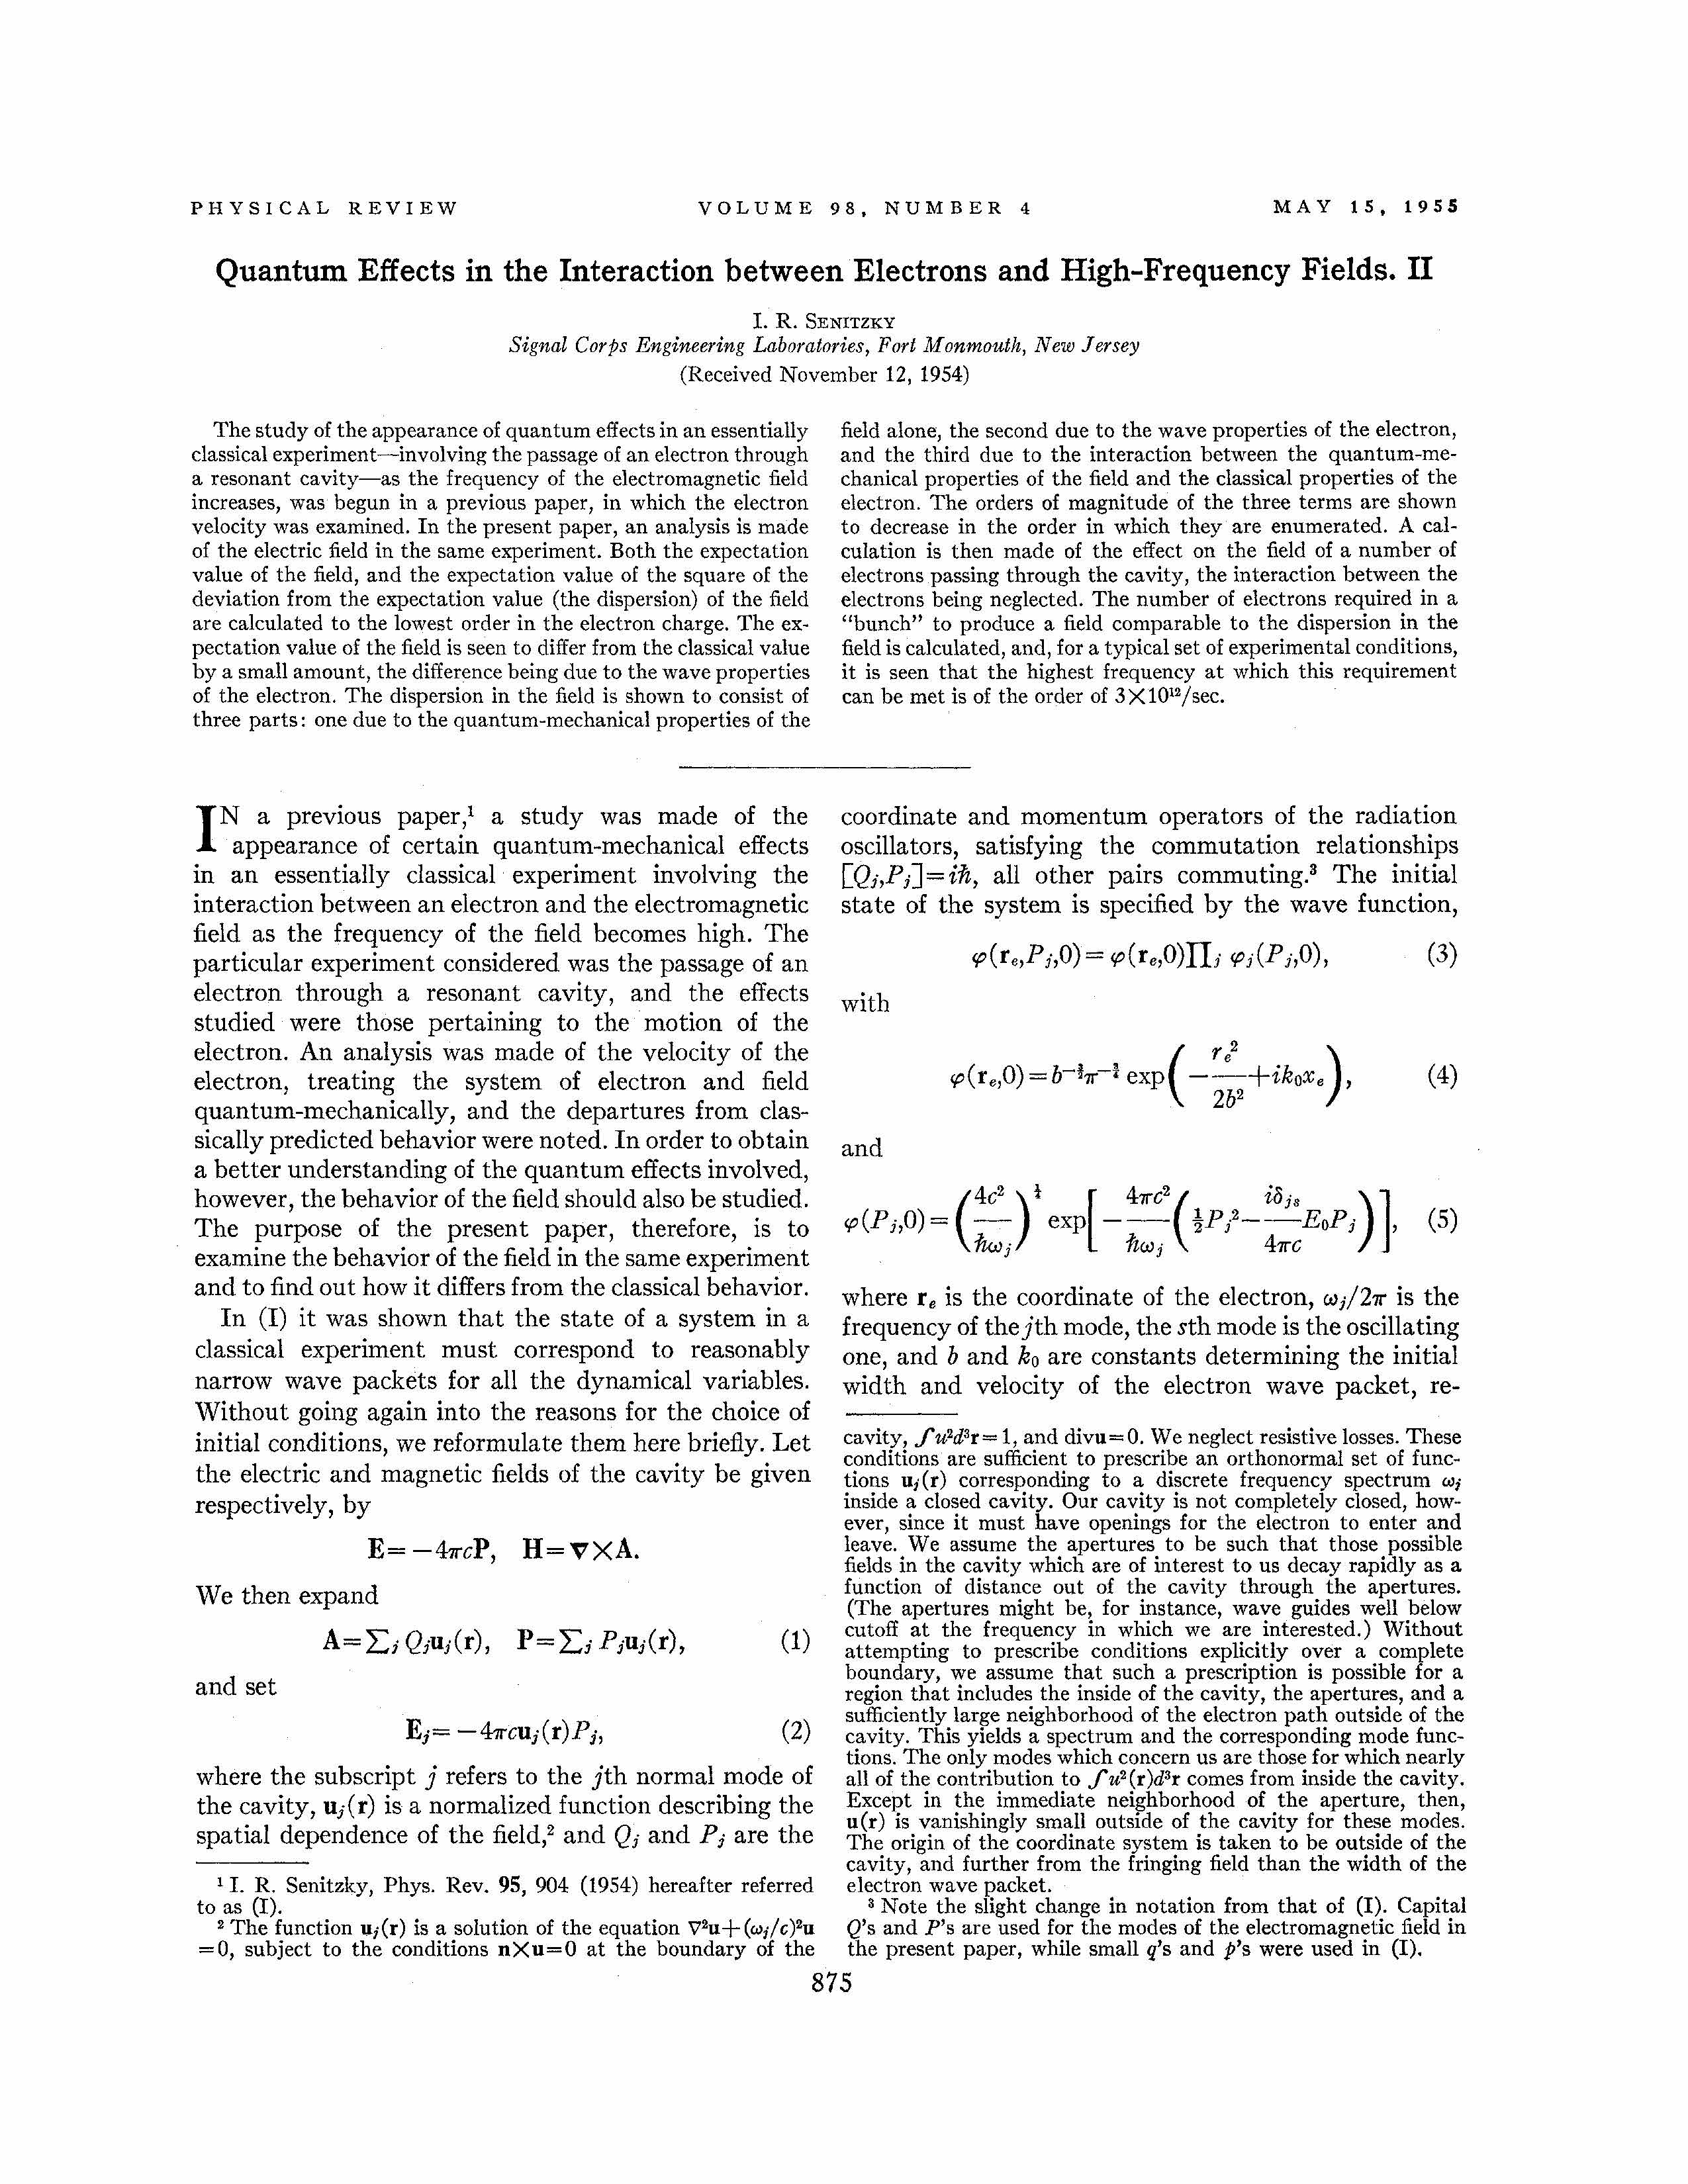

In [56]:
from IPython.display import Image
Image("../data/PhysRev.98.875.jpg", width=1000, height=1000)

Now let's go the other way around and find words most similar to this document:

In [58]:
apsD2V.docvecs.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ],
                             topn=5)

[('10.1103/PhysRev.98.875', 1.0),
 ('10.1103/PhysRev.95.904', 0.8127455115318298),
 ('10.1103/PhysRev.104.1486', 0.7313861846923828),
 ('10.1103/PhysRev.94.211', 0.6808601021766663),
 ('10.1103/PhysRev.90.682', 0.6720720529556274)]

We can even look for documents most like a query composed of multiple words:

In [59]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('positron', 0.7451556921005249),
 ('10.1103/PhysRev.98.1324', 0.7142689824104309),
 ('10.1103/PhysRev.87.454', 0.6975043416023254),
 ('10.1103/PhysRev.88.1350', 0.6849068403244019),
 ('10.1103/PhysRev.113.1545', 0.6735326647758484)]

Now let's plot some words and documents against one another with a heatmap:

In [60]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

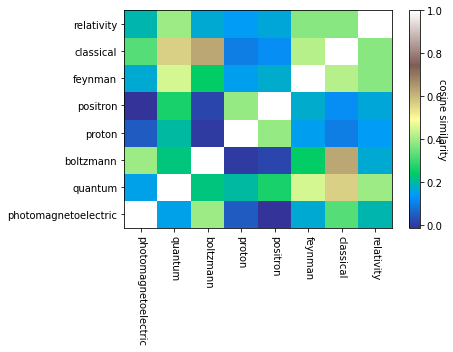

In [61]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [62]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

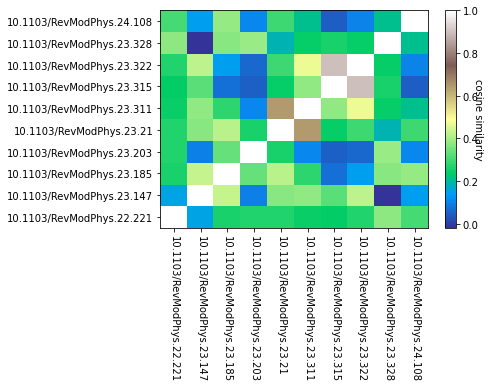

In [63]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [64]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

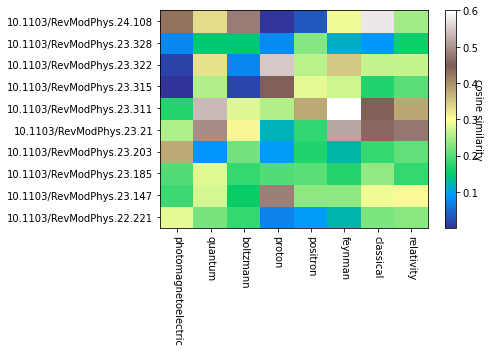

In [65]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [66]:
apsD2V.save('apsW2V')

We can later load it:

In [67]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project using `doc2vec`, and explore the relationship between different documents and the word vectors you analyzed in the last exercise. Consider the most similar words to critical documents, analogies (doc _x_ + word _y_), and other additions and subtractions that reveal the structure of similarity and difference within your semantic space. What does this pattern reveal about the documentary organization of your semantic space?

In [ ]:
taggedDocs = []
for index, row in netflix_overall.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.TaggedDocument(words =
                                                           row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [125]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [126]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
#wordsSubMatrix

In [127]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)

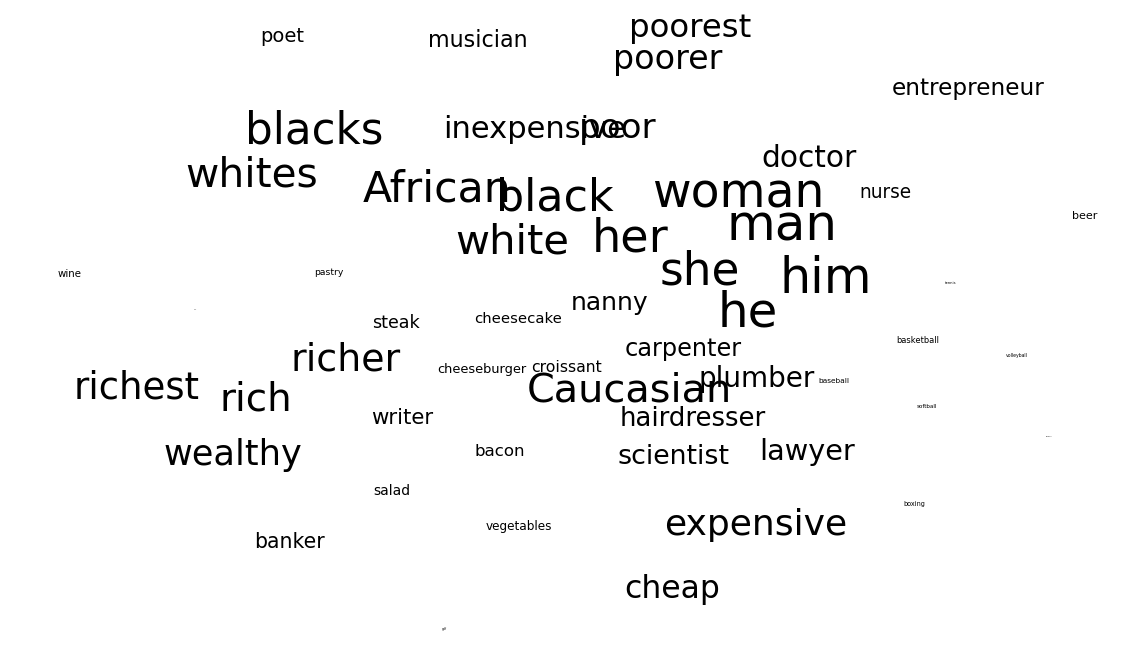

In [128]:
fig = plt.figure(figsize = (20,12))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  50 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [129]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [130]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [131]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [132]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pd.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [133]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)

Define some useful functions for plotting.

In [134]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())

Plot the occupational words in each of the three dimensions.

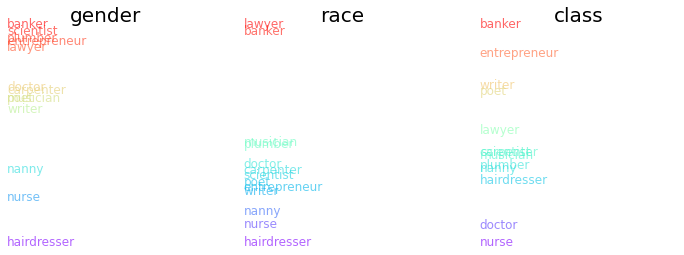

In [135]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()

Foods:

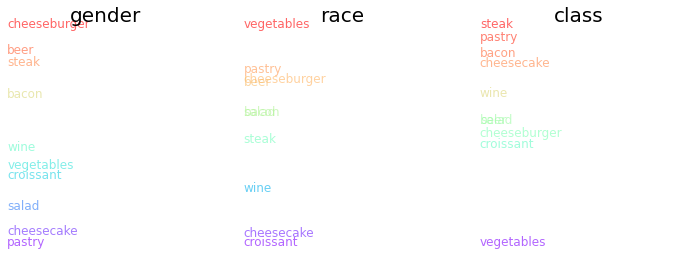

In [136]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

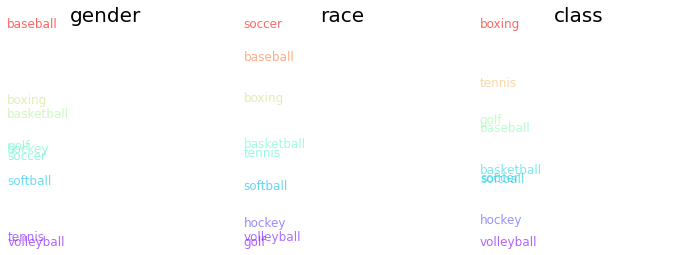

In [137]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that embed documents related to your final project, then generate meaningful semantic dimensions based on your theoretical understanding of the semantic space (i.e., by subtracting semantically opposite word vectors) and project another set of word vectors onto those dimensions. Interpret the meaning of these projections for your analysis. Which of the dimensions you analyze explain the most variation in the projection of your words and why? 

<font color="red">***Stretch***: Average together multiple antonym pairs to create robust semantic dimensions. How do word projections on these robust dimensions differ from single-pair dimensions?

# The Score Function

The score function is a simple calculation developed by [Matt Taddy](https://arxiv.org/pdf/1504.07295.pdf) to calculate the likelihood that a given text would have been generated by a word-embedding model by summing the inner product between each pair of the text's word vectors. This relies on a few data files that are not in the git repo due to their size please download and unzip [this](https://github.com/Computational-Content-Analysis-2018/Upcoming/raw/master/data/supplement.zip) (472MB) file in the data directory.

Here, we explore this using a model trained with millions of resumes from the CareerBuilder website (we can't share the private resumes...but we can share a model built with them :-):

In [138]:
resume_model  = gensim.models.word2vec.Word2Vec.load('../data/supplement/resumeAll.model')

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/Users/sudhamshu.hosamane/opt/anaconda3/lib/python3.8/site-packages/gensim/models/word2vec.py'>

We can examine the vacabularies of this model by building a word-index map:

In [ ]:
vocab = resume_model.wv.index2word

Let's just load the sample and take a look at it. The sentences in each job description are already tokenized and normalized.

In [ ]:
sampleDF = pd.read_csv('../data/SampleJobAds.csv', index_col = False)
#We need to convert the last couple columns from strings to lists
sampleDF['tokenized_sents'] = sampleDF['tokenized_sents'].apply(lambda x: eval(x))
sampleDF['normalized_sents'] = sampleDF['normalized_sents'].apply(lambda x: eval(x))
sampleDF

Let's define a function to calculate the likelihood of each job description. The idea is borrowed from [Matt Taddy](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/deepir.ipynb), who shows how a document can be characterized as the inner product of the distance between its words. In other words, this analysis will show which job ads are most likely to find an appropriate pool of workers in the resume bank that generated our word embedding.  

In [ ]:
def adprob(ad, model):
    sen_scores = model.score(ad, len(ad))
    ad_score = sen_scores.mean()
    return ad_score

Let's apply this function to every job description.

In [ ]:
sampleDF['likelihood'] = sampleDF['normalized_sents'].apply(lambda x: adprob(x, resume_model))

Let's take a look at the top 5 job descriptions that have the highest likelihood.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood', ascending = False)['jobDescription'][:5]:
    print (ad + '\n\n')

Let's take a look at the bottom 5 job descriptions that have the lowest likelihood to be matched by the resumes.

In [ ]:
for ad in sampleDF.sort_values(by = 'likelihood')['jobDescription'][:5]:
    print (ad + '\n\n')

We can do the same for phrases corresponding to job skills.

In [ ]:
adprob([["python", "programming"]], resume_model)

In [ ]:
adprob([["julia", "programming"]], resume_model)

Basic programming appears to be more likely in this pool of resumes than python programming. 

We can also do some simple statistics. Unfortunately, we don't have a large sample here. Nevertheless, let's first look at the mean likelihood score of each hiring organization. Some organizations will do well to hire on CareerBuilder...while others will not.

In [ ]:
sampleDF.groupby("hiringOrganization_organizationName")[['likelihood']].mean().sort_values('likelihood', ascending = False)

We can also look at the mean likelihood of each state.

In [ ]:
sampleDF.groupby("jobLocation_address_region")[['likelihood']].mean().sort_values('likelihood', ascending = False)

You would increase the sample size if you want to do a more serious study.

## <font color="red">*Exercise 4a*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that calculate the scores for a small sample of documents from outside your corpus to identify which are *closest* to your corpus. Then calculate the scores for a few phrases or sentences to identify the ones most likely to have appeared in your corpus. Interrogate patterns associated with these document/phrase scores (e.g., which companies produced job ads most or least likely to find jobseekers in the resume corpus?) What do these patterns suggest about the boundaries of your corpus?

# Linguistic Change or Difference

Below is code that aligns the dimensions of multiple embeddings arrayed over time or some other dimension and allow identification of semantic chanage as the word vectors change their loadings for focal words. This code comes from the approach piloted at Stanford by William Hamilton, Daniel Jurafsky and Jure Lescovec [here](https://arxiv.org/pdf/1605.09096.pdf). 

In [139]:
import copy

In [140]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

In order to explore this, let's get some data that follows a time trend. We'll look at conference proceedings from the American Society for Clinical Oncologists.

In [141]:
ascoDF = pd.read_csv("../data/supplement/ASCO_abstracts.csv", index_col=0)

Prepare for wor2vec:

In [ ]:
ascoDF['tokenized_sents'] = ascoDF['Body'].apply(lambda x: [lucem_illud.word_tokenize(s) for s in lucem_illud.sent_tokenize(x)])
ascoDF['normalized_sents'] = ascoDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s) for s in x])

/Users/sudhamshu.hosamane/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:187: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


KeyboardInterrupt: 

In [ ]:
ascoDF

We will be creating many embeddings so we have created this function to do most of the work. It creates two collections of embeddings, one the original and one the aligned.

In [ ]:
def compareModels(df, category, text_column_name='normalized_sents', sort = True, embeddings_raw={}):
    """If you are using time as your category sorting is important"""
    if len(embeddings_raw) == 0:
        embeddings_raw = rawModels(df, category, text_column_name, sort)
    cats = sorted(set(df[category]))
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [ ]:
def rawModels(df, category, text_column_name='normalized_sents', sort = True):
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF[text_column_name].sum())
    return embeddings_raw

Now we generate the models:

In [ ]:
rawEmbeddings, comparedEmbeddings = compareModels(ascoDF, 'Year')

In [ ]:
rawEmbeddings.keys()

We need to compare them across all permutions so we will define another function to help, we will be using 1 - cosine similarity as that gives a more intitive range of 0-2 with low values meaning little change and high meaning lots of change.

In [ ]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    print(word)
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pd.DataFrame(dists, index = cats)

Lets look at a couple words:

In [ ]:
targetWord = 'breast'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = 'combination'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [ ]:
wordDivergences = findMostDivergent(comparedEmbeddings)

The most divergent words are:

In [ ]:
wordDivergences[:20]

And the least:

In [ ]:
wordDivergences[-20:]

In [ ]:
targetWord = wordDivergences[0][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [ ]:
targetWord = wordDivergences[-1][0]

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

## COHA

COHA is a historial dataset so it ends up being a good choice to try the same analysis we just did across three different time periods.

We will be using the same data loading procedure as the last notebook, so go through the process to make sure you know what's going on.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud.loadDavies(corpora_address, return_raw=True)

Cool - let us now create our different epochs. This is an important step: I will be using the same 5 epochs I did in the DTM example, but you are recommended to play around with this. I will create a dataframe which logs the year and the genre.

In [ ]:
coha_df = pd.DataFrame(columns=["Year", "Genre", "Epoch", "normalized sents"])

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")

    year = int(year)
    
    if year > 1810 and year < 1880:
        epoch = 0
    if year >= 1880 and year < 1913:
        epoch = 1
    if year >= 1913 and year < 1950:
        epoch = 2
    if year >= 1950 and year < 1990:
        epoch = 3
    if year >= 1990:
        epoch = 4
    
    try:
        if len(coha_texts[article][2]) < 1500000:
            coha_df.loc[id_] = [year, genre, epoch, lucem_illud.normalizeTokens(coha_texts[article][2].decode("utf-8"), lemma=False)]
    except TypeError:
        continue
    except IndexError:
        continue

We can now arrange our word embeddings by either year, genre, or epoch, and see how the words in each of those contexts change.

In [ ]:
rawEmbeddings_epoch = rawModels(coha_df, 'Epoch', text_column_name='normalized sents')

In [ ]:
# rawEmbeddings_genre = rawModels(coha_df, 'Genre', text_column_name='normalized sents')

We now have the raw embeddings for epoch and genre. You can test out the previous analysis on words of your choice.

In [ ]:
for epoch, embedding in enumerate(rawEmbeddings_epoch):
    model = rawEmbeddings_epoch[embedding]
    name = "embedding_epoch_" + str(epoch)
    model.save(name)

In [ ]:
# for embedding in rawEmbeddings_genre:
#     model = rawEmbeddings_genre[embedding]
#     name = "embedding_genre_" + embedding
#     model.save(name)

In [ ]:
from gensim.models import Word2Vec

In [ ]:
def file_to_embeddings(address, kind):
    rawEmbeddings = {}
    for file in os.listdir(address):
        if "embedding_"+kind in file:
            e, kind_, kind_type = file.split("_")
            kind_type = eval(kind_type)
            rawEmbeddings[kind_type] = Word2Vec.load(file)
    return rawEmbeddings

In [ ]:
# rawEmbeddings_genre_load = file_to_embeddings(".", "genre")

In [ ]:
rawEmbeddings_epoch_load = file_to_embeddings(".", "epoch")

In [ ]:
rawEmbeddings_epoch_load.keys()

In [ ]:
rawEmbeddings_epoch, compared_epoch = compareModels(coha_df, 'Epoch', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_epoch_load)

In [ ]:
# rawEmbeddings_genre, compared_genre = compareModels(coha_df, 'Genre', text_column_name='normalized sents', embeddings_raw=rawEmbeddings_genre_load)

You now have access to the epoch wise embeddings, and the code to train models genre wise (commented out). You can use the original embeddings, the compared embeddings and such to perform the analysis we did before.

## <font color="red">*Exercise 4b*</font>

<font color="red">**Do only 4a or 4b.** Construct cells immediately below this that align word embeddings over time or across domains/corpora. Interrogate the spaces that result and ask which words changed most and least over the entire period or between contexts/corpora. What does this reveal about the social game underlying your space? 

There is much more we do not have time to cover on word embeddings. If you are interested in other ways to align word embeddings, take a look at the [Dynamic Word Embeddings (DTM) section from the Thinking with Deep Learning course](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=COS_n2RFCJNk) or using the more recent [Temporal Word Embeddings with a Compass (TWEC) package](https://github.com/valedica/twec). There is also a useful section on [debiasing word embeddings](https://colab.research.google.com/drive/1RAiI3BIL1X9D4gzZ0rZdIJjkNNicIuKE?usp=sharing#scrollTo=JHQ--EsWoxGM), such as the famous, ["Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings"](https://arxiv.org/abs/1607.06520) paper. Below, we include an optional section on topic modeling with word embeddings, which could be useful for final projects.

## Optional: Topic modeling with word embeddings

Recently computer scientists have developed methods to cluster word embeddings, which can be viewed as a topic model, an embedding-based version of conventional topic models that use the document-term matrix (e.g., LDA). One method is Discourse Atoms, first described by Princeton NLP researchers ([Arora et al. 2018](https://arxiv.org/abs/1601.03764)). This uses k-SVD, a generalization of the k-means clustering algorithm to identify topic-like vectors in the n-dimensional word embedding space. Below is code adapted from the first social science paper using Discourse Atoms, [Arseniev-Koehler et al. 2021](https://osf.io/preprints/socarxiv/nkyaq/). It takes as input _gensim_ word vectors.

You are not required to implement this, but for class projects or your own research, this can be more useful than conventional topic models. It runs faster, produces more detailed topics, and in general makes use of more information (i.e., word order within a document) than do conventional topic models. Note there are at least 4 other papers with methods for word embedding clusters:

- Xun, Li, Zhao, Gao, and Zhang 2017: [multivariate Gaussian distributions](https://www.ijcai.org/proceedings/2017/588)
- Dieng, Ruiz, and Blei 2019: ["Embedding Topic Model (ETM)"](https://arxiv.org/abs/1907.04907)
- Angelov 2020: ["Top2Vec"](https://arxiv.org/abs/2008.09470)
- Sia, Dalmia, and Mielke 2020: [(spherical) k-means, k-medoids, von Mises-Fisher Models, Gaussian Mixture Models](https://arxiv.org/abs/2004.14914)

Let's implement the Discourse Atoms method.

In [ ]:
# from gensim.test.utils import datapath 
# import re
# import string, re
# import cython

In [ ]:
# The ksvd package has a convenient Approximate k-SVD function.
!pip install ksvd

In [ ]:
from gensim import corpora, models, similarities #calc all similarities at once, from http://radimrehurek.com/gensim/tut3.html
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import KeyedVectors
from random import seed, sample
from ksvd import ApproximateKSVD #pip or conda install ksvd #this is key!

In [ ]:
import pickle

In [ ]:
import math

In [ ]:
# Load a gensim word2vec model
w2v = senReleasesW2V

#### k-SVD

We then perform a K-SVD on the word embedding matrix to learn topics in such a way where each word-vector is represented as a spare linear combination of topics. To generate a good representation of the original word vector space, we want to minimize the difference between our word vectors and the vectors generated as a linear combination of topics. 




In [ ]:
#### TRAIN MODEL:

#n_comp: Number of topics (i.e., atoms, or dictionary elements)
#n_nonzeros: Number of nonzero coefficients to target (how many atoms each word can load onto)
            
def do_aksvd(w2vmodel, n_comp, n_nonzeros, save=False, savelocation='/content/aksvd_models/'): 
    #https://github.com/nel215/ksvd #takes about 2 min on Alina's laptop for 30 atoms 
    aksvd_t = ApproximateKSVD(n_components=n_comp, transform_n_nonzero_coefs=n_nonzeros) #also may adjuste n iter which is default at 10, and tolerance for error which is default at  tol=1e-6 #n_components is number of discourse atoms, since vocab size is smallish, keep this fewer. transform_n is the number of atoms (components) that a word can be a linear combo of
    dictionary_t = aksvd_t.fit(w2vmodel.wv.vectors).components_ # Dictionary is the matrix of discourse atoms. 
    alpha_t = aksvd_t.transform(w2vmodel.wv.vectors) #get the alphas, which are the "weights" of each word on a discourse atoms

    if save==True:
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_aksvd_nvdrsdf20','wb')
        pickle.dump(aksvd_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' +str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_dictionary_nvdrsdf20','wb')
        pickle.dump(dictionary_t,outfile)
        outfile.close()
        
        outfile = open(str(savelocation) + '200d_' + str(n_comp) + 'comp' + str(n_nonzeros) + 'nonzeros_alpha_nvdrsdf20','wb')
        pickle.dump(alpha_t,outfile)
        outfile.close()
    return(dictionary_t, alpha_t)

Two quick quality checks. These are useful to choose the number of atoms in the dictionary (i.e., number of topics): $R^2$ and Topic Diversity

Useful to look at product of the two since $R^2$ tends to increase with higher # topics, as Topic Diversity decreases. Intuition: more topics can better explain the original semantic space, but also then these topics are less distinct from one another. As a result, we typically want a balance between the two.

In [ ]:
def reconst_qual(w2vmodel, dictionary_mat, alpha_mat):
    #reconstruct the word vectors
    reconstructed = alpha_mat.dot(dictionary_mat) #reconstruct word vectors and add back in mean(?). but note that reconstructed norm is still around 0-1, not 1, is that an issue?
    #e1 = norm(w2vmodel.wv.vectors - reconstructed) #total reconstruction error, larger means MORE error. norm as specified here takes frobenius norm of error matrix.


    #total VARIANCE in the data: sum of squares 
    squares3= w2vmodel.wv.vectors-np.mean(w2vmodel.wv.vectors, axis=1).reshape(-1,1) #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sst3= np.sum([i.dot(i) for i in squares3] ) #same as below

    sst3= np.sum(np.square(squares3))


    #total sum of squared ERRORS/residuals
    e3= [reconstructed[i]-w2vmodel.wv.vectors[i] for i in range(0,len(w2vmodel.wv.vectors))]  #https://dziganto.github.io/data%20science/linear%20regression/machine%20learning/python/Linear-Regression-101-Metrics/
    #sse3= np.sum([i.dot(i) for i in e3] ) #same as below
    sse3= np.sum(np.square(e3))

    #R^2: 1- (SSE / SST )
    r2= 1- (sse3 /  sst3) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error


    #compute root mean square error
    rmse=  math.sqrt(np.mean(np.square(e3)))



    return(sse3, rmse, r2) #https://stats.stackexchange.com/questions/184603/in-pca-what-is-the-connection-between-explained-variance-and-squared-error

#### Inferring topics from document

We now use a similar approach to what we saw a little earlier, where we inverted our generative model to see which documents belong to which class - we do the same now, but with discourse atoms instead of the whole model. This process tells us the topic most likely to have generated a specific context (document). 



In [ ]:
#topic diversity (% unique words among total closest 25 words to each atom)
def topic_diversity(w2vmodel, dictionary_mat, top_n=25):

    topwords=[] #list of list, each innter list includes top N words in that topic

    for i in range(0, len(dictionary_mat)): #set to number of total topics
        topwords.extend([i[0] for i in w2vmodel.wv.similar_by_vector(dictionary_mat[i],topn=top_n)]) #set for top N words 
        #print(w2vmodel.wv.similar_by_vector(dictionary[i],topn=N))

    uniquewords= set(topwords)
    diversity = len(uniquewords)/len(topwords)
    return(diversity)

In [ ]:
dictionary, alpha = do_aksvd(w2v, 150, 5, save=True)

In [ ]:
topic_diversity(w2v, dictionary, top_n=25)

In [ ]:
reconst_qual(w2v, dictionary, alpha)


In [ ]:
#loading back in the model pieces if not already in

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_dictionary_nvdrsdf20','rb')
# dictionary=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_aksvd_nvdrsdf20','rb')
# aksvd=pickle.load(infile)
# infile.close()

# infile = open('../data/aksvd_models/200d_150comp5nonzeros_alpha_nvdrsdf20','rb')
# alpha=pickle.load(infile)
# infile.close()

In [ ]:
for i in range(0, len(dictionary)):
    print("Discourse_Atom " + str(i))
    print([i[0] for i in w2v.wv.similar_by_vector(dictionary[i],topn=25)]) #what are the most similar words to the Nth
    #print([i[0] for i in w2vmodel.wv.similar_by_vector(-dictionary[i],topn=25)]) #what are the most similar words to the Nth dicourse atom?
    print('\n')


In [ ]:
# for a specific atom, e.g., 112th atom look at 25 most similar words:
w2v.wv.similar_by_vector(dictionary[112],topn=25)

In [ ]:
print(w2v.wv.vocab.get('the').index, '\n', alpha[w2vmodel.wv.vocab.get('the').index])



In [ ]:
#useful relevant code:
#w2vmodel.wv.index2word[3452]
#w2vmodel.wv.most_similar('the', topn=15)
#np.where(alpha[w2vmodel.wv.vocab.get('the').index] != 0) #get index where the loading of a word onto discourse atoms is not 0